# A/B тест:
____

In [1]:
###
https://www.youtube.com/watch?v=O4hHKjM4Q64
https://drive.google.com/drive/folders/1tfsOz3tYov06RH7-BVDcP-85i8xhmxbz

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

In [2]:
### не устанавливается :(
!conda install bootstrapped

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - bootstrapped

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
###
#Для boostrap
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [3]:
#Для дата фреймов и расчетов
import pandas as pd
import numpy as np
from scipy.stats import shapiro, mannwhitneyu

#Для визуализации
import seaborn as sns
from matplotlib import pyplot as plt

In [29]:
###
sns.set()

A/B–тестирование:
1.1 Условие:
- Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные:
В качестве входных данных Вы имеете 3 csv-файла:
1. groups.csv : файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
2. active_studs.csv : файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
3. checks.csv : файл с информацией об оплатах пользователей в дни проведения эксперимента.

Скачать файлы можно [тут](https://drive.google.com/drive/folders/1zLEn-1ypfyvmBGevFXjZgCmiy6BEOmc1?usp=sharing)

1.3 Вопросы:
Предлагаем Вам ответить на следующие вопросы:
1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

1. При выполнении тестового задания необходимо использовать язык программирования Python.
2. В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.
3. Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [4]:
active_studs = pd.read_csv("active_studs.csv")
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [5]:
checks = pd.read_csv("checks.csv", sep=";")
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [6]:
groups = pd.read_csv("groups.csv", sep=";")
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


Сначала проведем базовую пред обработку данных и проведем a/b тест после исследование:

In [7]:
display(groups.shape[0], checks.shape[0], active_studs.shape[0])

74576

541

8341

In [ ]:
### наличие пропусков проверим

In [8]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [10]:
active_studs.isna().sum()

student_id    0
dtype: int64

Сначала предлагаю переименовать колонки, конечно, можно использовать right_on и left_on при мердже, но удобнее будет им просто поменять имена.

In [11]:
groups.rename(columns={"id": "student_id"}, inplace=True)

In [12]:
groups.shape[0]

74576

In [13]:
checks.shape[0]

541

In [14]:
active_studs.shape[0]

8341

Снизу для себя опишу для чего нужен каждый датасет:
1. В датафрейме active_studs находятся студенты, которые заходили в приложение во время эксперимента;
2. В датафрейме groups находятся студенты, которые были распределены на тестовую и контрольную группы во время эксперимента;
3. В датафрейме active_studs находятся студенты, которые оплатили что-то во время эксперимента в приложение.

Я бы сразу хотел смерджить все дата фреймы, чтобы понять, есть ли у нас совпадения между дата фреймами.

In [14]:
groups.merge(active_studs)

,student_id,grp
0,946259,B
1,1896859,B
2,938570,A
3,4808409,B
4,3242161,B
...,...,...
8336,1524221,B
8337,1302888,A
8338,1778339,B
8339,1138474,A


In [15]:
active_studs.merge(checks)

,student_id,rev
0,1184303,1530.0000
1,3354191,1900.0001
2,3278734,1900.0000
3,720651,1980.0000
4,1232221,1900.0000
...,...,...
387,3890326,199.0000
388,1390994,398.0000
389,1516339,290.0000
390,3910596,597.0000


А вот здесь строк стало явно меньше и причин здесь может быть несколько:
1. У пользователей, которые не были занесены ни в какую группу, были списаны деньги за подписку на нашем сервисе;
2. У пользователей, которые не были занесены ни в какую группу, были списаны деньги за услуги, не получившиеся оплатить сразу, и оплата произошла позже.

Теперь стоит смержить дата фреймы, а потом присоединить дата фрейм с группой во время эксперимента:

In [16]:
real_students = active_studs.merge(checks)
real_students = real_students.merge(groups)
real_students.head()

,student_id,rev,grp
0,1184303,1530.0000,A
1,3354191,1900.0001,B
2,3278734,1900.0000,B
3,720651,1980.0000,A
4,1232221,1900.0000,B


In [16]:
###
real_students = active_studs.merge(checks).merge(groups)
real_students.head()

,student_id,rev,grp
0,1184303,1530.0000,A
1,3354191,1900.0001,B
2,3278734,1900.0000,B
3,720651,1980.0000,A
4,1232221,1900.0000,B


Теперь стоит посмотреть на распределения в выборках и сколько студентов находится в каждой группе:

In [17]:
real_students.query("grp == 'A'").shape[0]

78

In [18]:
real_students.query("grp == 'B'").shape[0]

314

In [19]:
(78 / 314) * 100

24.840764331210192

Процент соотношения групп 25:75 тестовой:контрольной.
А теперь посмотрю на распределения:

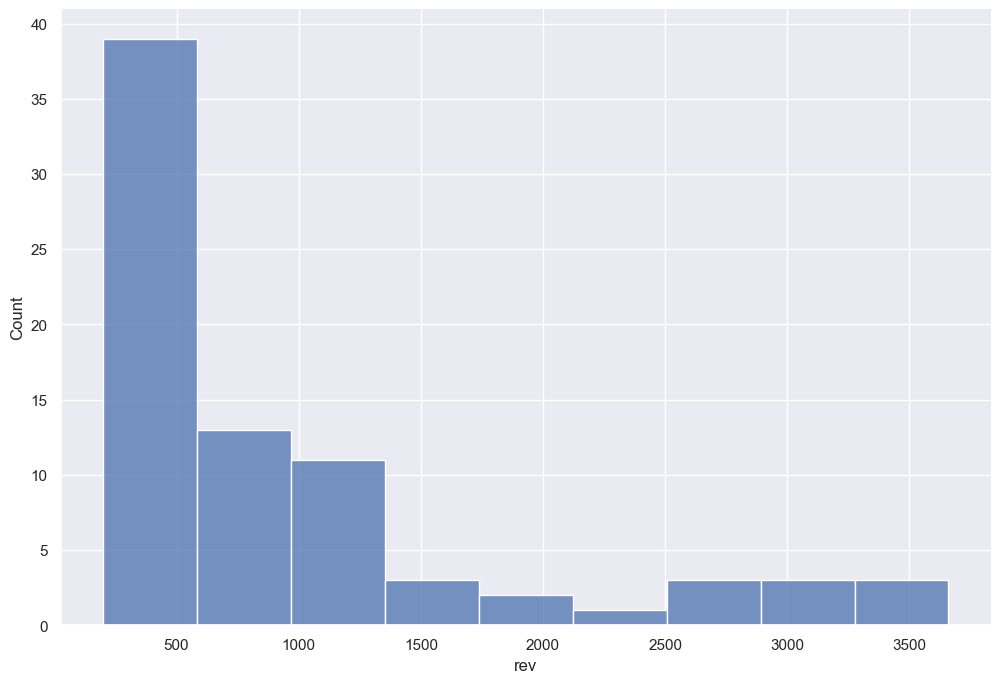

In [30]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query(
    "grp == 'A'").rev)  #Использую histplot вместо distplot так как в новых версиях будет доступен только первый вариант
sns.despine()  ## удаляет служебные записи?

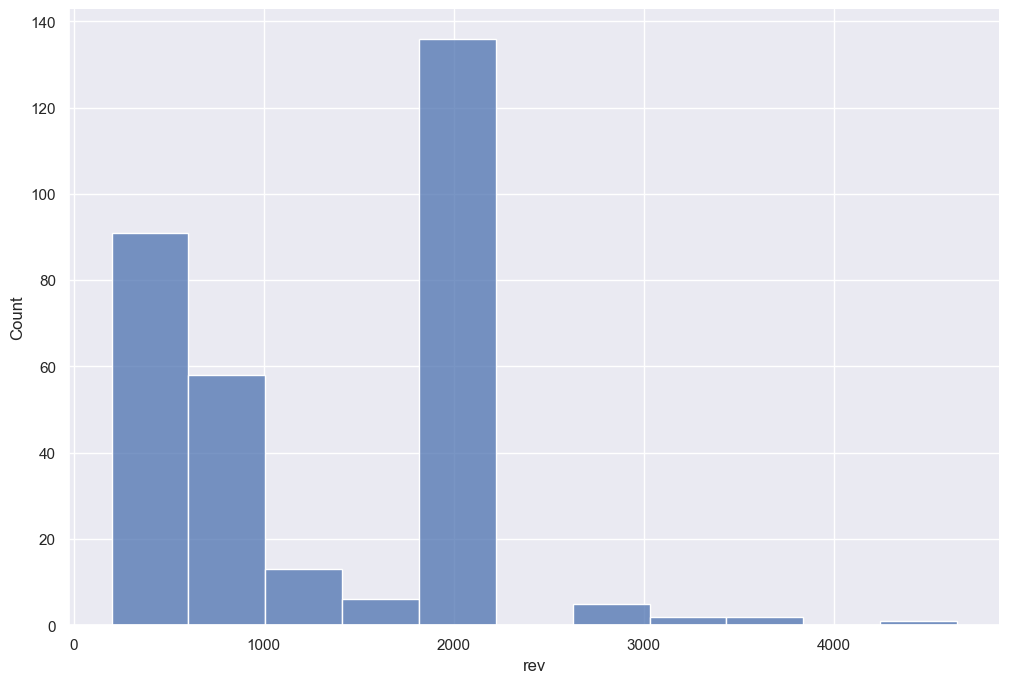

In [31]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query("grp == 'B'").rev)
sns.despine()

In [32]:
print(shapiro(real_students.query("grp == 'A'").rev), shapiro(real_students.query("grp == 'B'").rev), sep="\n")

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


И по графикам и при помощи теста можно подтвердить, что распределения явно ненормальные.
Можно попробовать применить логарифмическую трансформацию на наши данные:

In [33]:
real_students["log_rev"] = np.log(real_students.rev)

In [34]:
a_group = real_students.query("grp == 'A'")
b_group = real_students.query("grp == 'B'")

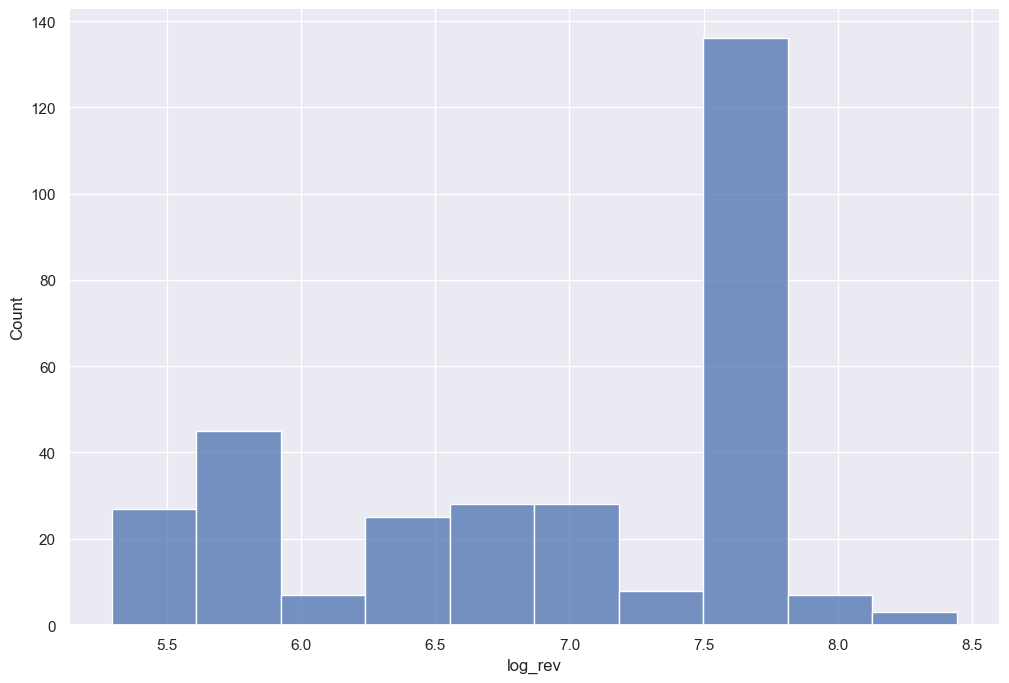

In [35]:
plt.figure(figsize=(12, 8))
sns.histplot(b_group.log_rev)
sns.despine()

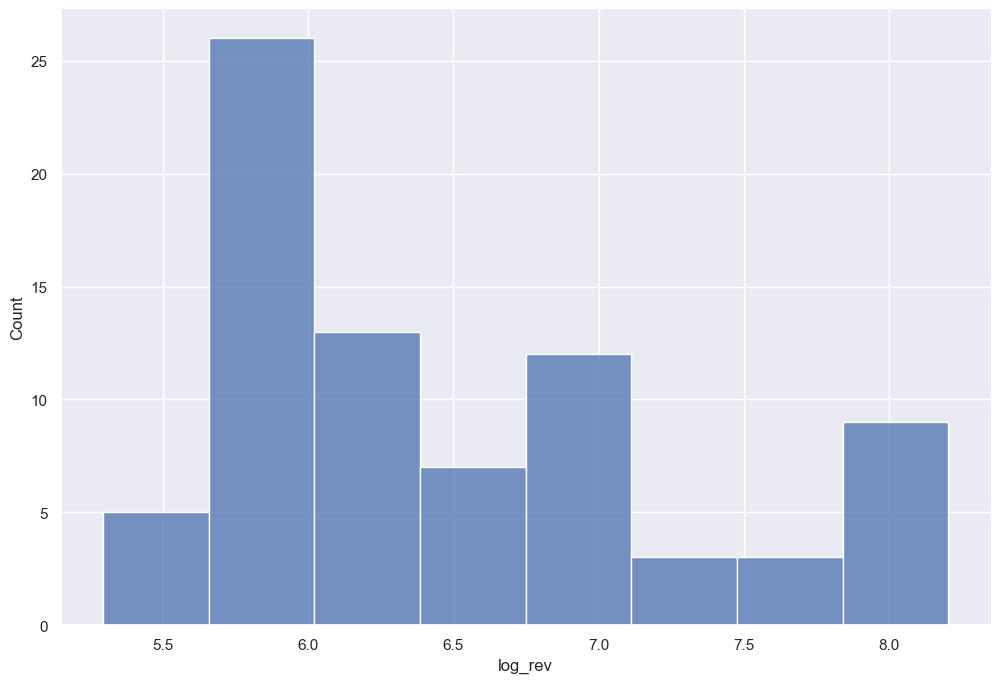

In [36]:
plt.figure(figsize=(12, 8))
sns.histplot(a_group.log_rev)
sns.despine()

In [37]:
print(shapiro(a_group.log_rev), shapiro(b_group.log_rev), sep="\n")

ShapiroResult(statistic=0.9057686924934387, pvalue=2.680935176613275e-05)
ShapiroResult(statistic=0.8419413566589355, pvalue=2.9242029102554055e-17)


In [ ]:
### не помогло. Совсем

А теперь давайте проверим несколько гипотез, сначала проверим гипотезу о том, что распределение признака в первой выборке соответствует распределению признака во второй выборке:

In [38]:
mannwhitneyu(a_group.rev, b_group.rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Разница все таки есть, а теперь проверим гипотезу о медианном значении в чеке в разных группах и таким образом H0 - медианное значения в группах равны:

In [39]:
print(a_group.rev.median(), b_group.rev.median(), sep="\n")

585.0
1140.0


In [40]:
## bootsrapped работает с нумпаевскими массивами
a_group_rev = np.array(a_group.rev)
b_group_rev = np.array(b_group.rev)

In [ ]:
### набутсрапим медиану и ее доверительный интервал. Точно? Какое странно название для него и нигде уровень доверия не назначили

In [36]:
print(bs.bootstrap_ab(a_group_rev, b_group_rev, bs_stats.median, bs_compare.percent_change))

-48.68421052631579    (-65.18451300665456, -26.661350345560862)


Доверительный интервал не захватывает 0 и поэтому можно считать, что следует отклонить H0, также хотел бы посоветовать дополнительный материал по [bootstrap](https://www.youtube.com/watch?v=-zps6hm0nX8&t=2493s).

### Выводы:
____
В ходе эксперимента было выявлено, что разница в группах на основе ниже приведенных выводов:
1. Разницу между распределениями в 2 группах есть, что показал первый анализ;
2. Разницу медианных значений в двух группах есть и в тестовой группе это значение больше, что показал 2 анализ.

На основе исследований, я бы ввел в наше приложение фичу, которая была в тестовой группе.

##### Дополнительно:
В дальнейшем было бы очень интересно посмотреть данные в разрезе стран или каких-то особых пакетов.